In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('dark_background')

In [26]:
# load the dataset
df = pd.read_csv('/content/drive/MyDrive/Tensorflow/TimeSeries/AirPassengers.csv')
print(df.dtypes)
df.head()

Month          object
#Passengers     int64
dtype: object


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Passengers    int64
dtype: object
            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


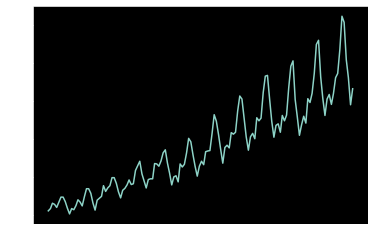

In [27]:
df['Month'] = pd.to_datetime(df['Month'])
df['Passengers']=df['#Passengers']
df.set_index('Month', inplace=True) 
df = df.drop(columns = ['#Passengers'])
print(df.dtypes)
print(df.head())
plt.plot(df['Passengers'])

In [29]:
#Is the data stationary?
#Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df['Passengers'])
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")

pvalue =  0.9918802434376411  if above 0.05, data is not stationary


In [31]:
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
years = df['year'].unique()
print(years)

[1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960]


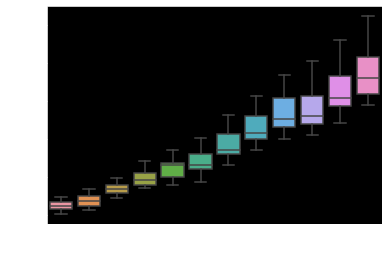

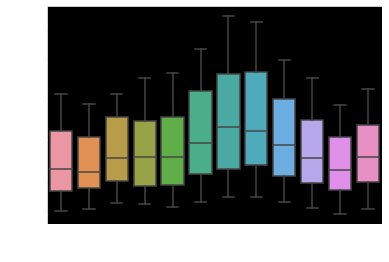

In [35]:
#Plot yearly and monthly values as boxplot
plt.figure()
sns.boxplot(x='year', y='Passengers', data=df)
plt.show()
plt.figure()
sns.boxplot(x='month', y='Passengers', data=df)
plt.show()

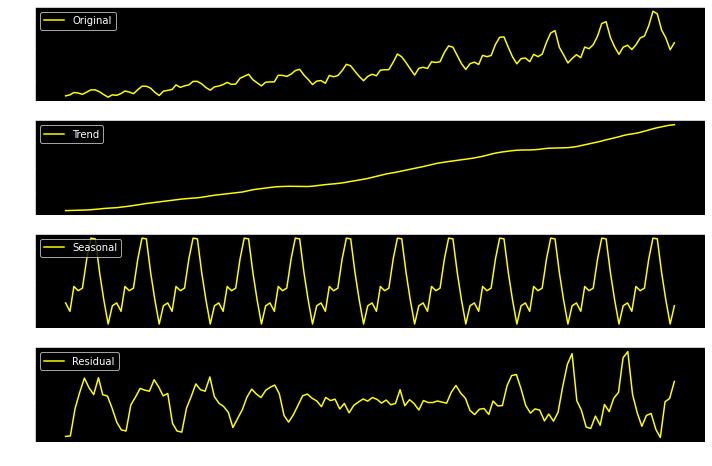

In [36]:
#Extract and plot trend, seasonal and residuals. 
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(df['Passengers'],  
                            model ='additive')

#Additive time series:
#Value = Base Level + Trend + Seasonality + Error
#Multiplicative Time Series:
#Value = Base Level x Trend x Seasonality x Error

trend = decomposed.trend
seasonal = decomposed.seasonal #Cyclic behavior may not be seasonal!
residual = decomposed.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df['Passengers'], label='Original', color='yellow')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='yellow')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='yellow')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='yellow')
plt.legend(loc='upper left')
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


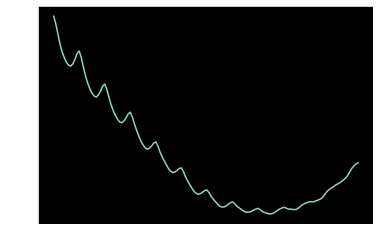

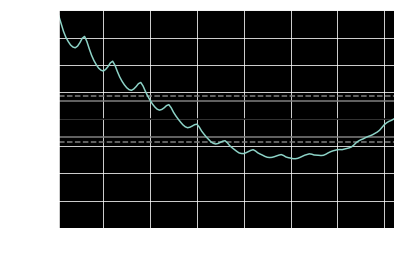

In [40]:
#AUTOCORRELATION
#Autocorrelation is simply the correlation of a series with its own lags.
# Plot lag on x axis and correlation on y axis
#Any correlation above confidence lnes are statistically significant.

from statsmodels.tsa.stattools import acf

acf_144 = acf(df.Passengers, nlags=144)
plt.plot(acf_144)
plt.show()
#Obtain the same but with single line and more info...
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df.Passengers) 
#Horizontal bands indicate 95% and 99% (dashed) confidence bands

#A strong positive correlation for lags below 40 (months)

In [47]:
#We can go through the exercise of making the data stationary and performing ARIMA
#Or let auto_arima provide the best model (e.g. SARIMA) and parameters. 
#Auto arima suggests best model and parameters based on 
#AIC metric (relative quality of statistical models)
!pip install pmdarima
!pip install statsmodels
!pip pip install --upgrade pandas
from statsmodels.compat.pandas import Appender
from pmdarima.arima import auto_arima
#Autoarima gives us bet model suited for the data
# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components
arima_model = auto_arima(df['Passengers'], start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50)           
  
# To print the summary 
print(arima_model.summary() ) #Note down the Model and details.
# Model: SARIMAX(0, 1, 1)x(2, 1, [], 12)

ERROR: unknown command "pip"


ImportError: ignored

In [ ]:
#Split data into train and test
size = int(len(df) * 0.66)
X_train, X_test = df[0:size], df[size:len(df)]

# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(X_train['Passengers'],  
                order = (0, 1, 1),  
                seasonal_order =(2, 1, 1, 12)) 
  
result = model.fit() 
result.summary() 

In [ ]:
#Train prediction
start_index = 0
end_index = len(X_train)-1
train_prediction = result.predict(start_index, end_index) 

#Prediction
start_index = len(X_train)
end_index = len(df)-1
prediction = result.predict(start_index, end_index).rename('Predicted passengers') 
#Rename the column

# plot predictions and actual values 
prediction.plot(legend = True) 
X_test['Passengers'].plot(legend = True)

In [ ]:
import math
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(X_train, train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(X_test, prediction))
print('Test Score: %.2f RMSE' % (testScore))

#from sklearn.metrics import r2_score
#score = r2_score(X_test, prediction)
#print("R2 score is: ", score)

In [ ]:
#Forecast.. You can re-train on the entire dataset before forecasting
#For now let us use the trained model
# Forecast for the next 3 years 
forecast = result.predict(start = len(df),  
                          end = (len(df)-1) + 3 * 12,  
                          typ = 'levels').rename('Forecast') 
  
plt.figure(figsize=(12,8))
plt.plot(X_train, label='Training', color='green')
plt.plot(X_test, label='Test', color='yellow')
plt.plot(forecast, label='Forecast', color='cyan')
plt.legend(loc='Left corner')
plt.show()
